# Advanced Data Analysis with Polars


_Data Umbrella Talk • 08 October 2024 • Kimberly Fessel, [Dr Kim Data](https://www.drkimdata.com)_

## Import Polars

In [80]:
import polars as pl

## Load and Explore Dataset

For this notebook, we'll use the famous 2015 Flight Delays and Cancellations dataset from the US Department of Transportation. 

You can get a copy of the [three related files](https://www.kaggle.com/datasets/usdot/flight-delays) in CSV format via Kaggle.

### LazyFrame

To utilize Polar's lazy evaluation options, load in data using the `scan_csv()` function. This function doesn't do much yet and gives you a LazyFrame object. 

In [2]:
lf  = pl.scan_csv('data/flights.csv')

In [3]:
type(lf)

polars.lazyframe.frame.LazyFrame

### Lazy Evaluation

At this point, your data has not been loaded into memory. Most methods only give you a plan instead of your actual results.

In [4]:
lf.head()

To ask Polars to actually process your code, add `.collect()` at the end.

In [5]:
lf.head().collect()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
2015,1,1,4,"""AS""",98,"""N407AS""","""ANC""","""SEA""",5,2354,-11,21,15,205,194,169,1448,404,4,430,408,-22,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",2336,"""N3KUAA""","""LAX""","""PBI""",10,2,-8,12,14,280,279,263,2330,737,4,750,741,-9,0,0,null,null,null,null,null,null
2015,1,1,4,"""US""",840,"""N171US""","""SFO""","""CLT""",20,18,-2,16,34,286,293,266,2296,800,11,806,811,5,0,0,null,null,null,null,null,null
2015,1,1,4,"""AA""",258,"""N3HYAA""","""LAX""","""MIA""",20,15,-5,15,30,285,281,258,2342,748,8,805,756,-9,0,0,null,null,null,null,null,null
2015,1,1,4,"""AS""",135,"""N527AS""","""SEA""","""ANC""",25,24,-1,11,35,235,215,199,1448,254,5,320,259,-21,0,0,null,null,null,null,null,null


This allows Polars the option to be able to perform all your actions in the most efficient way possible rather than in sequence.

By the way, this dataset has over 5 million rows.

In [6]:
lf.select(pl.len()).collect().item()

5819079

Here's a more complicated request that finds the average of non-negative delays for each airline and sorts results from greatest to least.

In [7]:
(
    lf.select(['AIRLINE','ARRIVAL_DELAY'])
      .filter(pl.col('ARRIVAL_DELAY') > 0)
      .group_by('AIRLINE')
      .mean()
      .sort("ARRIVAL_DELAY", descending=True)
)

Now we'll add `.collect()` to have Polars execute its plan and give us our results.

In [8]:
(
    lf.select(['AIRLINE','ARRIVAL_DELAY'])
      .filter(pl.col('ARRIVAL_DELAY') > 0)
      .group_by('AIRLINE')
      .mean()
      .sort("ARRIVAL_DELAY", descending=True)
).collect()  #Add .collect() to execute the code

AIRLINE,ARRIVAL_DELAY
str,f64
"""F9""",41.190435
"""NK""",40.659852
"""MQ""",39.509202
"""UA""",39.209314
"""B6""",38.132807
…,…
"""VX""",30.725227
"""WN""",29.418496
"""US""",27.419925


## Transformations

Polars offers many transformations and aggregations natively. Here are some more advanced things Polars can do.

### String Concatenation

You can concatenate strings from various columns using `concat_str()`. 

Here we also cast some numerical columns to strings (`.cast(pl.String)`) and pad them with zeros (`.str.zfill()`) to create a datetime stamp.

In [9]:
(
    lf.select(
        pl.concat_str([
            pl.col('MONTH').cast(pl.String).str.zfill(2),
            pl.col('DAY').cast(pl.String).str.zfill(2),
            pl.col('SCHEDULED_DEPARTURE').cast(pl.String).str.zfill(4)
        ], separator='-').alias('datetime')
    )
).head(10).collect()

datetime
str
"""01-01-0005"""
"""01-01-0010"""
"""01-01-0020"""
"""01-01-0020"""
"""01-01-0025"""
"""01-01-0025"""
"""01-01-0025"""
"""01-01-0030"""
"""01-01-0030"""


### Window Functions

Polars can do so-called "window functions" with `.over()`. You can do this type of action in SQL with `OVER` and in pandas with `.transform()`.

In [10]:
(
    lf.filter(pl.col('ARRIVAL_DELAY') > 0)
      .select(
            pl.concat_str([
                pl.col('MONTH').cast(pl.String).str.zfill(2),
                pl.col('DAY').cast(pl.String).str.zfill(2),
                pl.col('SCHEDULED_DEPARTURE').cast(pl.String).str.zfill(4)
            ],separator='-').alias('datetime'),
          'AIRLINE',
          'ORIGIN_AIRPORT',
          'ARRIVAL_DELAY',
          pl.col('ARRIVAL_DELAY').mean().alias('avg_overall'),
          pl.col('ARRIVAL_DELAY').mean().over('AIRLINE').alias('avg_delay_by_airline'),
          pl.col('ARRIVAL_DELAY').mean().over(['AIRLINE', 'ORIGIN_AIRPORT']).alias('avg_delay_by_airline_origin'),
      )
).collect()

datetime,AIRLINE,ORIGIN_AIRPORT,ARRIVAL_DELAY,avg_overall,avg_delay_by_airline,avg_delay_by_airline_origin
str,str,str,i64,f64,f64,f64
"""01-01-0020""","""US""","""SFO""",5,33.11299,27.419925,20.231721
"""01-01-0025""","""DL""","""SFO""",8,33.11299,32.077424,32.231875
"""01-01-0040""","""DL""","""SEA""",8,33.11299,32.077424,23.106662
"""01-01-0055""","""NK""","""LAS""",6,33.11299,40.659852,40.928709
"""01-01-0100""","""AA""","""SEA""",1,33.11299,34.148364,26.436942
…,…,…,…,…,…,…
"""12-31-2358""","""NK""","""FLL""",28,33.11299,40.659852,35.584615
"""12-31-2359""","""B6""","""LAS""",159,33.11299,38.132807,37.963155
"""12-31-2359""","""B6""","""SLC""",17,33.11299,38.132807,29.390476


### User-defined Functions

Polars offers many built-in functions and methods, but if you have something more customized you'd like to do, Polars also accepts user-defined functions (UDFs) via `.map_elements()` (individual elements) or `.map_batches()` (whole Series).

Say we'd like to compute the difference between each flight's actual delay and the average delay for this dataset (for flights with delays). 

In [11]:
(
    lf.filter(pl.col('ARRIVAL_DELAY') > 0)
      .select(
          'ARRIVAL_DELAY',
          pl.col('ARRIVAL_DELAY').mean().alias('avg_overall'),
          #pl.col('ARRIVAL_DELAY') - pl.col('avg_overall')  ##produces error, avg_overall column not available
      )
).collect()

ARRIVAL_DELAY,avg_overall
i64,f64
5,33.11299
8,33.11299
8,33.11299
6,33.11299
1,33.11299
…,…
28,33.11299
159,33.11299
17,33.11299


Let's try building a user-defined function (UDF) to compute the difference from average.

In [12]:
def diff_from_mean(series):
    
    #Initialize total
    total = 0
    
    #Sum the series
    for value in series:
        total += value
        
    #Compute mean
    mean = total/len(series)  
    
    #Return Polars Series of differences from mean
    return pl.Series([value - mean for value in series])

In [13]:
(
    lf.filter(pl.col('ARRIVAL_DELAY') > 0)
      .select(
          'ARRIVAL_DELAY',
          pl.col('ARRIVAL_DELAY').mean().alias('avg_overall'),
          pl.col('ARRIVAL_DELAY').map_batches(diff_from_mean).alias('diff_from_avg')
      )
).collect()

ARRIVAL_DELAY,avg_overall,diff_from_avg
i64,f64,f64
5,33.11299,-28.11299
8,33.11299,-25.11299
8,33.11299,-25.11299
6,33.11299,-27.11299
1,33.11299,-32.11299
…,…,…
28,33.11299,-5.11299
159,33.11299,125.88701
17,33.11299,-16.11299


_Note: Implementing pure-Python UDFs via `.map_elements()` or `.map_batches()` can be slow. See Polars documentation about [ufuncs](https://docs.pola.rs/user-guide/expressions/user-defined-functions/#fast-operations-with-user-defined-functions) and [processing with Numba](https://docs.pola.rs/user-guide/expressions/user-defined-functions/#example-a-fast-custom-function-using-numba) for speedier options._

## Processing SQL Queries

While its own functions and methods will likely give you faster results, Polars does offer support for processing SQL queries if you have pre-existing SQL code you'd like to use.

We'll load one additional DataFrame of related data to demonstrate SQL capabilities.

In [14]:
airports_df = pl.read_csv('data/airports.csv')

airports_df.head()

IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
str,str,str,str,str,f64,f64
"""ABE""","""Lehigh Valley International Ai…","""Allentown""","""PA""","""USA""",40.65236,-75.4404
"""ABI""","""Abilene Regional Airport""","""Abilene""","""TX""","""USA""",32.41132,-99.6819
"""ABQ""","""Albuquerque International Sunp…","""Albuquerque""","""NM""","""USA""",35.04022,-106.60919
"""ABR""","""Aberdeen Regional Airport""","""Aberdeen""","""SD""","""USA""",45.44906,-98.42183
"""ABY""","""Southwest Georgia Regional Air…","""Albany""","""GA""","""USA""",31.53552,-84.19447


To get started with SQL in Polars, first we need to set up our SQL context and register any DataFrames/LazyFrames we'd like to use.

In [15]:
ctx = pl.SQLContext(flights=lf, airports=airports_df)

Now you can run SQL queries on these tables using `.execute()`. The `eager=True` part makes the query go ahead and run instead of being lazy.

In [17]:
ctx.execute('SELECT * FROM airports LIMIT 5;', eager=True)

IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
str,str,str,str,str,f64,f64
"""ABE""","""Lehigh Valley International Ai…","""Allentown""","""PA""","""USA""",40.65236,-75.4404
"""ABI""","""Abilene Regional Airport""","""Abilene""","""TX""","""USA""",32.41132,-99.6819
"""ABQ""","""Albuquerque International Sunp…","""Albuquerque""","""NM""","""USA""",35.04022,-106.60919
"""ABR""","""Aberdeen Regional Airport""","""Aberdeen""","""SD""","""USA""",45.44906,-98.42183
"""ABY""","""Southwest Georgia Regional Air…","""Albany""","""GA""","""USA""",31.53552,-84.19447


In [23]:
query = ''' 
    SELECT a.AIRPORT AS origin, 
           MIN(a.STATE) AS state, 
           COUNT(f.ARRIVAL_DELAY) AS delayed_flights, 
           AVG(f.ARRIVAL_DELAY) AS avg_delay
    FROM flights f LEFT JOIN airports a
    ON f.ORIGIN_AIRPORT = a.IATA_CODE
    WHERE f.ARRIVAL_DELAY > 0
    GROUP BY a.AIRPORT
    ORDER BY avg_delay DESC
'''

ctx.execute(query, eager=True)

origin,STATE,delayed_flights,avg_delay
str,str,u32,f64
"""Barnstable Municipal Airport""","""MA""",21,88.047619
"""Martha's Vineyard Airport""","""MA""",70,68.4
"""Greater Binghamton Airport""","""NY""",70,62.342857
"""Valdez Airport""","""UT""",23,61.173913
"""Del Norte County Airport (Jack…","""CA""",59,60.728814
…,…,…,…
"""Honolulu International Airport""","""HI""",15463,19.114984
"""Lewiston-Nez Perce County Airp…","""ID""",97,18.752577
"""Westerly State Airport""","""MT""",58,18.034483


## Data Visualization

If you have installed Polars with the plotting option (`pip install 'polars[plot]'`), you can plot directly from your dataframes.

In [75]:
airports_df.plot.point(x='LONGITUDE', y='LATITUDE', tooltip = 'AIRPORT')

alt.Chart(...)

You will need to collect information from a LazyFrame before plotting, however.

In [47]:
pl.Series(
    (
        lf.select('ARRIVAL_DELAY')
          .filter(pl.col('ARRIVAL_DELAY') > 0)
          .collect()
          .sample(500, seed=4)
    )
).plot.hist()

alt.Chart(...)

Polars currently uses Altair as its backend plotting engine. 

If you have some other preferred plotting library (such as Matplotlib, Seaborn, Plotly, hvPlot), you can use that instead by importing it.

In [48]:
import seaborn as sns

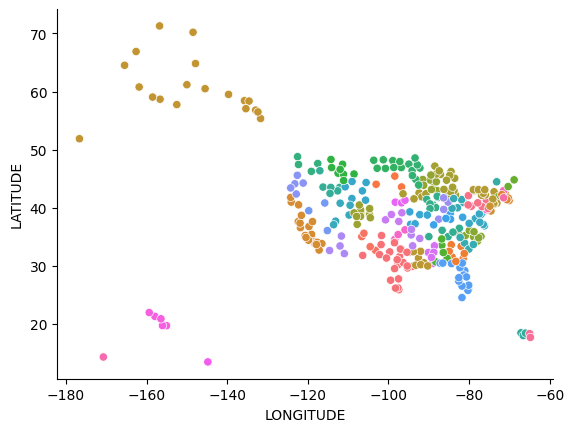

In [77]:
sns.scatterplot(
    data = airports_df,
    x = 'LONGITUDE',
    y = 'LATITUDE',
    hue = 'STATE',
    legend = False
)

sns.despine();

### Converting to pandas

And you can always convert Polars into pandas with `.to_pandas()` if all else fails!

In [60]:
import pandas as pd

In [61]:
df = airports_df.to_pandas()

In [62]:
type(df)

pandas.core.frame.DataFrame

In [63]:
df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [73]:
df.STATE.value_counts().sort_index()

STATE
AK    19
AL     5
AR     4
AS     1
AZ     4
CA    22
CO    10
CT     1
DE     1
FL    17
GA     7
GU     1
HI     5
IA     5
ID     6
IL     7
IN     4
KS     4
KY     4
LA     7
MA     5
MD     1
ME     2
MI    15
MN     8
MO     5
MS     5
MT     8
NC     8
ND     8
NE     3
NH     1
NJ     3
NM     4
NV     3
NY    14
OH     5
OK     3
OR     5
PA     8
PR     3
RI     1
SC     4
SD     3
TN     5
TX    24
UT     5
VA     7
VI     2
VT     1
WA     4
WI     8
WV     1
WY     6
Name: count, dtype: int64

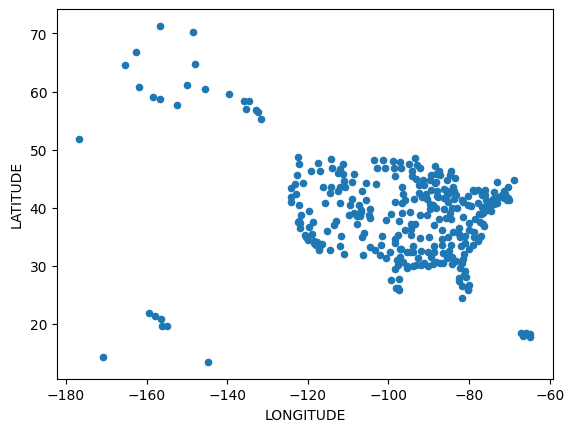

In [79]:
df.plot(x='LONGITUDE', y='LATITUDE', kind='scatter');